In [1]:
%load_ext autoreload
%autoreload 2
import notebook_setup
from src.config import INTERIM_DATA_DIR, PROCESSED_DATA_DIR, REPORTS_DIR, EXTERNAL_DATA_DIR, MODELS_DIR
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
os.environ["OMP_NUM_THREADS"] = "4"
os.environ["MKL_NUM_THREADS"] = "4"

BREPNET_NPZ_DIR = INTERIM_DATA_DIR / "features" / "brepnet"

2025-09-23 13:36:37.871 | INFO     | src.config:<module>:11 - PROJ_ROOT path is: D:\workspace\projects\freelance\Fusion3DNet


Project root added to path: d:\workspace\projects\freelance\Fusion3DNet


In [2]:
import numpy as np
from pathlib import Path
files = list(Path(BREPNET_NPZ_DIR).glob("*.npz"))

feats = np.load(files[0], allow_pickle=True)

for k, v in feats.items():
    print(k, v.shape)

face_features (9, 7)
face_point_grids (9, 7, 10, 10)
edge_features (16, 10)
coedge_point_grids (31, 12, 10)
coedge_features (31, 1)
coedge_lcs (31, 4, 4)
coedge_scale_factors (31,)
coedge_reverse_flags (31,)
next (31,)
mate (31,)
face (31,)
edge (31,)


In [3]:
from src.modeling.ssl_graph_brep.data_module.brep_dataset import BRepNPZDataset

dataset = BRepNPZDataset(BREPNET_NPZ_DIR)
print(f"Dataset length: {len(dataset)}")
g = dataset.get(0)
print(g)

for k, v in g.items():
    print(k, v.shape if hasattr(v, "shape") else v)

Dataset length: 129
HeteroData(
  face={
    x=[9, 7],
    uv=[9, 7, 10, 10],
    num_nodes=9,
  },
  edge={
    x=[16, 10],
    num_nodes=16,
  },
  coedge={
    x=[31, 1],
    grid=[31, 12, 10],
    lcs=[31, 4, 4],
    scale=[31],
    reverse=[31],
    num_nodes=31,
  },
  (coedge, next, coedge)={ edge_index=[2, 31] },
  (coedge, mate, coedge)={ edge_index=[2, 31] },
  (coedge, to_face, face)={ edge_index=[2, 31] },
  (coedge, to_edge, edge)={ edge_index=[2, 31] }
)


In [11]:
from src.modeling.ssl_graph_brep.data_module.brep_data_loader import BRepDataModule
data_module = BRepDataModule(BREPNET_NPZ_DIR, batch_size=32, num_workers=0)
data_module.setup()

batch = next(iter(data_module.train_dataloader()))
def validate_topology(batch):
    next_edges = batch[("coedge","next","coedge")].edge_index
    mate_edges = batch[("coedge","mate","coedge")].edge_index
    
    # Проверить валидность связей
    print(f"Next edges: {next_edges.shape}")
    print(f"Mate edges: {mate_edges.shape}")
    print(f"Max coedge index: {batch['coedge'].num_nodes}")

validate_topology(batch)

Next edges: torch.Size([2, 14259])
Mate edges: torch.Size([2, 14259])
Max coedge index: 14259


In [ ]:
from src.modeling.ssl_graph_brep import train


train.run(
    npz_brep_dir=BREPNET_NPZ_DIR,
    batch_size=32,
    epochs=10,
    num_workers=4,
    proj_dim=512,
    lr=5e-5,
    hidden=256,
    tau=0.2,
    lambda_topo_next=8.0,
    lambda_topo_mate=8.0,
    aug_p=0.0,
    topo_tau=0.05,
    weight_decay=1e-3,
    validation_ratio=0.2,
    test_ratio=0.1,
    )

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:701: Checkpoint directory D:\workspace\projects\freelance\Fusion3DNet\models\ssl_brep exists and is not empty.

  | Name        | Type                | Params | Mode 
------------------------------------------------------------
0 | face_enc    | UVNetSurfaceEncoder | 439 K  | train
1 | coedge_enc  | UVNetCurveEncoder   | 192 K  | train
2 | edge_lin    | Linear              | 2.8 K  | train
3 | gnn         | BRepHeteroGNN       | 396 K  | train
4 | readout     | AttnReadout         | 131 K  | train
5 | projector   | Sequential          | 525 K  | train
6 | scorer_next | BilinearScorer      | 262 K  | train
7 | scorer_mate | BilinearScorer      | 262 K  | train
------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:428: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
d:\dev\.miniconda\envs\brepnet\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_infoNCE_acc improved. New best score: 0.922


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_infoNCE_acc improved by 0.015 >= min_delta = 0.0. New best score: 0.937


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_infoNCE_acc improved by 0.008 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_infoNCE_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.945


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_infoNCE_acc improved by 0.004 >= min_delta = 0.0. New best score: 0.949


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_infoNCE_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.951


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


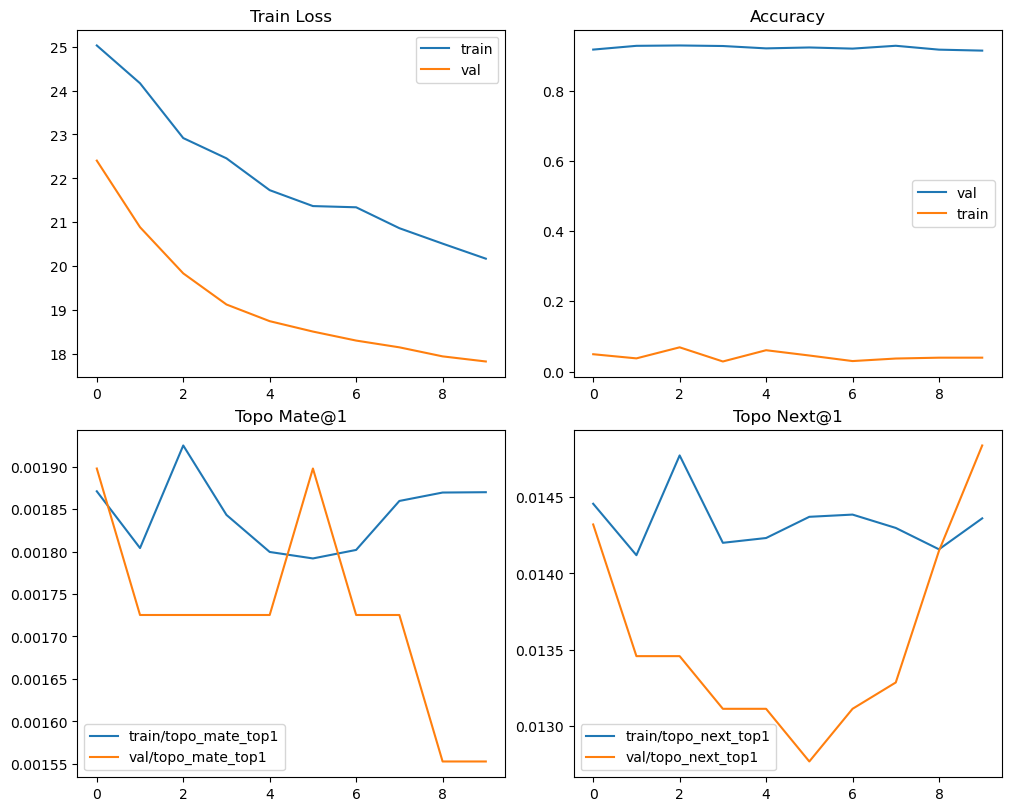

In [6]:
from src.modeling.ssl_graph_brep import plots

metrics_csv = REPORTS_DIR / "ssl_brep" / "version_2" / "metrics.csv"

plots.plot_training_curves(metrics_csv)

In [7]:
from src.modeling.ssl_graph_brep.inference import extract_embeddings, topk_similar, search_by_name

ckpt = MODELS_DIR / "ssl_brep" / "ssl-brep-epoch=02-val_infoNCE_acc=0.928.ckpt"
# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / "42. Ejector"
data_dir = Path(BREPNET_NPZ_DIR)
ids, E = extract_embeddings(ckpt, data_dir)

topk_idx = topk_similar(E, k=10)
for i, nn_idx in enumerate(topk_idx[:15]):
    print("Query:", ids[i])
    print("Top-10:", [ids[j] for j in nn_idx])
    print("---")

Query: 42. Ejector-01.prt
Top-10: ['42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector-04.prt', '42. Ejector-02', '42. Ejector.prt', '42. Ejector-03.prt', '42. Ejector-07.prt', '42. Ejector-08.prt', '42. Ejector-09.prt']
---
Query: 42. Ejector-02
Top-10: ['42. Ejector-02', '42. Ejector-03.prt', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-04.prt', '42. Ejector-06.prt', '42. Ejector.prt', '42. Ejector-09.prt', '42. Ejector-07.prt', '42. Ejector-08.prt']
---
Query: 42. Ejector-03.prt
Top-10: ['42. Ejector-03.prt', '42. Ejector-02', '42. Ejector-04.prt', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-06.prt', '42. Ejector.prt', '42. Ejector-09.prt', '42. Ejector-07.prt', '42. Ejector-10.prt']
---
Query: 42. Ejector-04.prt
Top-10: ['42. Ejector-04.prt', '42. Ejector-01.prt', '42. Ejector-05.prt', '42. Ejector-03.prt', '42. Ejector-06.prt', '42. Ejector-09.prt', '42. Ejector-02', '42. Ejector.prt', '42. Ejector-07.prt', '42. Ejector-08.prt']


In [9]:
import pandas as pd

class_name = "43. Extractor-09"

# BREPNET_NPZ_DIR = PROCESSED_DATA_DIR / "test" / "features" / class_name

ids, E = extract_embeddings(model_ckpt=ckpt, data_dir=BREPNET_NPZ_DIR)


results = search_by_name(ids, E, query_name=f"{class_name}", include_self=True, max_print=30)

# report_name = 'graph_report.xlsx'

# df = pd.DataFrame(results, columns=['q', 'acc', 'name'] )
# report_path = REPORTS_DIR / report_name  # 'graph_report.xlsx'
# mode = 'a' if Path(report_path).exists() else 'w'  # append или создать
# with pd.ExcelWriter(report_path, engine="openpyxl", mode=mode) as writer:
#     df.to_excel(writer, sheet_name=class_name, index=False)


Запрос: 43. Extractor-09.prt
   1. 100.00%  43. Extractor-09.prt
   2.  99.82%  43. Extractor-10.prt
   3.  99.59%  43. Extractor-04.prt
   4.  99.55%  43. Extractor-06.prt
   5.  99.55%  43. Extractor-05.prt
   6.  99.34%  43. Extractor-07.prt
   7.  99.25%  Колодка приклада.prt
   8.  99.24%  Колодка приклада 2.prt
   9.  99.23%  Колодка приклада 1.prt
  10.  99.22%  Колодка приклада 3.prt
  11.  99.19%  Колодка приклада 5.prt
  12.  99.19%  Колодка приклада 4.prt
  13.  99.17%  43. Extractor-08.prt
  14.  99.15%  Колодка приклада 8.prt
  15.  99.14%  Колодка приклада 7.prt
  16.  99.13%  Колодка приклада 6.prt
  17.  99.05%  Колодка приклада 9.prt
  18.  99.05%  Колодка прицельная.prt
  19.  99.01%  Колодка прицельная 1.prt
  20.  99.00%  Колодка прицельная 6.prt
  21.  99.00%  Колодка прицельная 3.prt
  22.  99.00%  Колодка прицельная 4.prt
  23.  98.99%  Камера газовая 6.prt
  24.  98.96%  Колодка прицельная 5.prt
  25.  98.94%  Колодка прицельная 8.prt
  26.  98.94%  Колодка при